In [1]:
!module list

Currently Loaded Modulefiles:
 1) singularity   2) openmpi/4.1.5   3) NCI-ai-ml/24.08   4) pbs  
>

In [2]:
from math import ceil
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import torch
import numpy as np

import sys,os,time
wdir1="/g/data/z00/yxs900/neuraloperators/sfno/curriculum_learning/lowRes/experiments/05_LUCIE_rm_pos_embed/"
sys.path.append(wdir1)
from torch_harmonics_local_v2 import *


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    
device

device(type='cuda', index=0)

In [6]:
# prepare the autoregressive dataset
from torch.utils.data import DataLoader
nb_dir="/g/data/z00/yxs900/neuraloperators/sfno/curriculum_learning/lowRes"
sys.path.append(nb_dir)
from datasets import WBDataset


ddir = "/g/data/wb00/admin/testing/t_WeatherBench"
dpth_str = f"{ddir}/wb2*.nc"
cpth = f"{ddir}/constants_1.40625deg.nc"
mpth = f"{ddir}/all_means.npy"
spth = f"{ddir}/all_stds.npy"
rpth = f"{ddir}/all_res.npy"
avs = list(np.load(f"{ddir}/ordering.npy"))
vs = ["tisr","t850","q850","u500","v500"] # add tp in the future
idx = [avs.index(vi) for vi in vs]
vc = ["lat2d","lon2d","lsm"]
nsamples = 87600 # 10y hourly
idx_start = 3
#vsamples = 17520 # 2y hourly
nworkers = 10

samples = WBDataset(dpth_str,cpth,in_chans=vs, out_chans=vs, const_chans=vc, norm_paths=[mpth,spth],idx=idx, nsamples=nsamples)
v = torch.utils.data.Subset(samples,list(range(idx_start,nsamples,6)))
vdl = DataLoader(v, shuffle=False, batch_size=1, num_workers=nworkers,drop_last=True)

v.indices[:10], len(v.indices), len(vdl)

([3, 9, 15, 21, 27, 33, 39, 45, 51, 57], 14600, 14600)

In [7]:
# prep for plotting.

# read in lat, lon grid
from netCDF4 import Dataset as ncDataset
with ncDataset(cpth, 'r') as ds:
    Lat= ds['lat2d'][:].data
    Lon= ds['lon2d'][:].data

# set figure size
w,h = 5,4
vars = vs
nvars=len(vars)

In [8]:
Lat.shape

(128, 256)

In [10]:
# load the best RMSE trained model 
nlat, nlon = Lat.shape
n_in_channels, n_out_channels = 8, 5
hard_thresholding_fraction = 0.9
model = SphericalFourierNeuralOperatorNet(params = {"data_grid":"equiangular"}, spectral_transform='sht', filter_type = "linear", operator_type='dhconv', img_shape=(nlat, nlon),num_layers=8, in_chans=n_in_channels, out_chans=n_out_channels, scale_factor=1, embed_dim=72, activation_function="silu", big_skip=True, pos_embed=False, use_mlp=True,normalization_layer="instance_norm", hard_thresholding_fraction=hard_thresholding_fraction,mlp_ratio = 2.).to(device)

wdir=f"{nb_dir}/experiments/061_LUCIE_no_pos_embed_wb1.4"
jobid="143815943"
ei="82"
ckp = torch.load(f'{wdir}/checkpoints/{jobid}.gadi-pbs/lucie_{ei}.pt')
model.load_state_dict(ckp["model_state_dict"])

<All keys matched successfully>

In [13]:
def rollout_model_tisr_forcing(vdl, model, device="cuda"):
    asteps=len(vdl)
    pred = torch.zeros(asteps,5,128,256)
    targ = torch.zeros(asteps,5,128,256)

    model.eval()
    with torch.no_grad():
        for ii, data in enumerate(vdl, 0):
            #print(f"step {ii}, inp shape = {data[0].shape}, tar shape = {data[1].shape}")
            inp, tar = map(lambda x: x.to(device, dtype = torch.float32), data)
            if ii==0:
                prd = inp
            else:
                prd = torch.concatenate((inp[:,:4,:,:], prd[:,1:,:,:]),axis=1)

            prd = model(prd)
            pred[ii,:] = prd.cpu()
            targ[ii,:] = tar.cpu()

    return pred,targ

In [15]:
# run the rollout for 10y
pp,tt = rollout_model_tisr_forcing(vdl, model)

# Check the Spatial Pattern

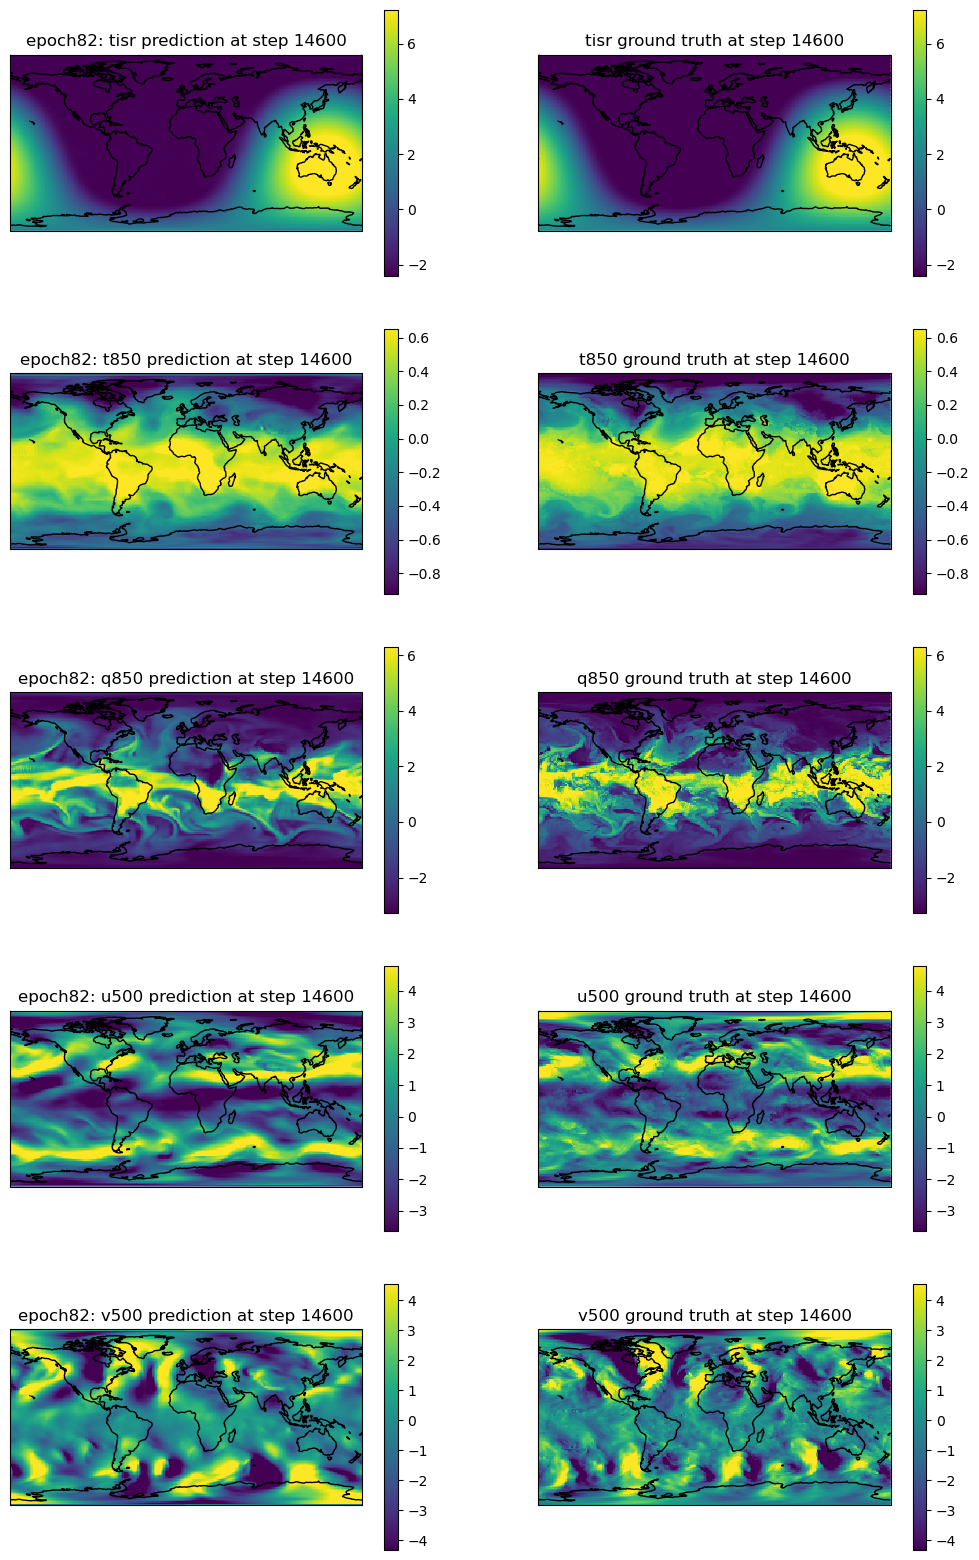

In [16]:
ss = pp.shape[0]
fig,axs = plt.subplots(nvars,2, figsize=(w*2.5,h*nvars),subplot_kw={'projection': ccrs.PlateCarree()},squeeze=False)
for ii in range(nvars):
    pii = pp[ss-1,ii,:,:]
    tii = tt[ss-1,ii,:,:]
    combined_values = np.concatenate([pii.flatten(), tii.flatten()])
    cmin, cmax = np.nanquantile(combined_values, [0.05, 0.95])
        
    pcm = axs[ii,0].pcolormesh(Lon,Lat,pii,vmin=cmin, vmax=cmax,cmap='viridis', shading='auto')
    axs[ii,0].coastlines()
    axs[ii,0].set_title(f"epoch{ei}: {vars[ii]} prediction at step {ss}")
    fig.colorbar(pcm, ax=axs[ii,0])
    
    pcm1 = axs[ii,1].pcolormesh(Lon,Lat,tii,vmin=cmin, vmax=cmax,cmap='viridis', shading='auto')
    axs[ii,1].coastlines()
    axs[ii,1].set_title(f"{vars[ii]} ground truth at step {ss}")
    fig.colorbar(pcm1, ax=axs[ii,1])

# Compare Global Mean over Time

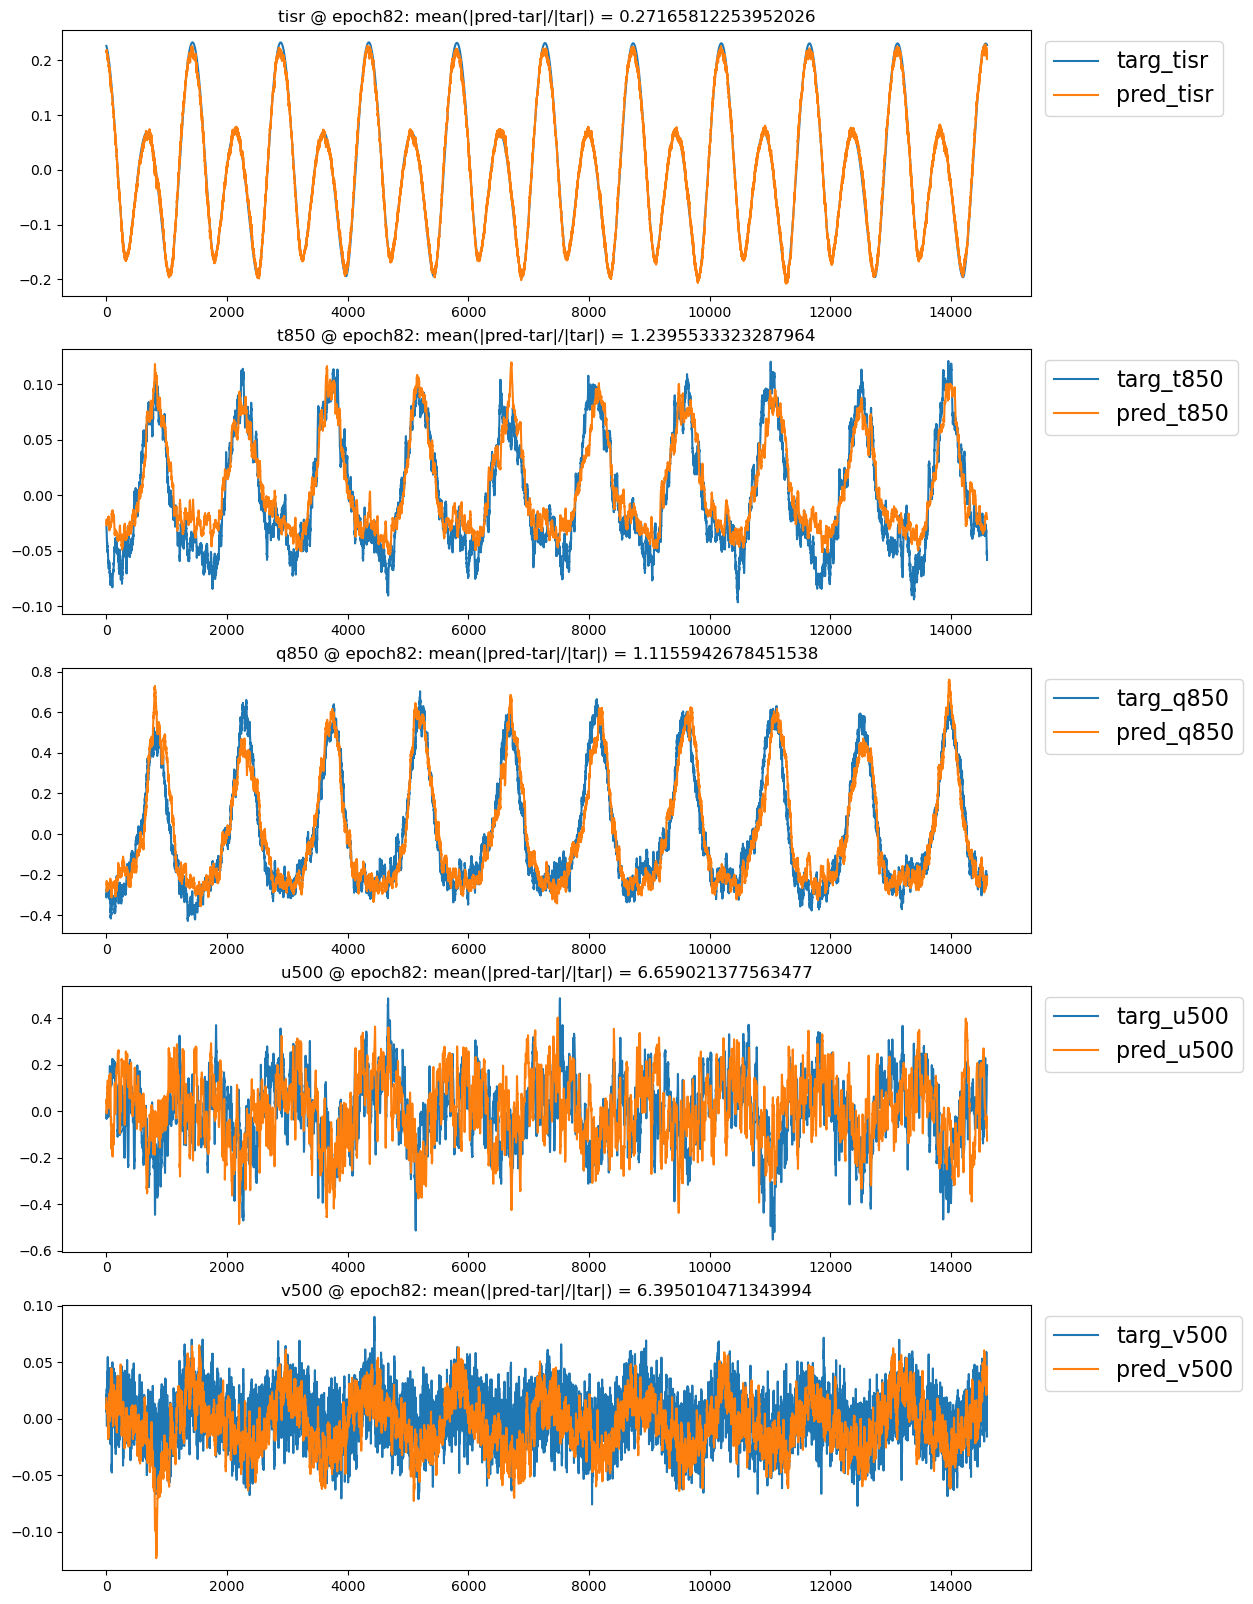

In [18]:
true_clim_t = torch.mean(tt,dim=(-1,-2))
pred_clim_t = torch.mean(pp,dim=(-1,-2))
fig,axs = plt.subplots(nvars,1, figsize=(w*2.5,h*nvars))
for ii in range(nvars):
    pcm1 = axs[ii].plot(true_clim_t[:,ii],label=f"targ_{vars[ii]}")
    pcm2 = axs[ii].plot(pred_clim_t[:,ii],label=f"pred_{vars[ii]}")
    axs[ii].set_title(f"{vars[ii]} @ epoch{ei}: mean(|pred-tar|/|tar|) = {torch.mean(torch.abs(true_clim_t[:,ii] - pred_clim_t[:,ii])/torch.abs(true_clim_t[:,ii]))}")
    axs[ii].legend(loc='upper left', bbox_to_anchor=(1.003, 1),fontsize=16)

# Check Climate Bias by Vars

In [26]:
# 10y mean clim_bias, it is expected to be different from what reported in the training 
print(pp.shape)
true_clim = torch.mean(pp[1460:],dim=0)
pred_clim = torch.mean(tt[1460:],dim=0)

clim_bias = torch.mean(torch.abs(true_clim - pred_clim))
clim_bias

torch.Size([14600, 5, 128, 256])


tensor(0.2224)

In [31]:
#true_clim_t = torch.mean(tt,dim=(-1,-2))
#pred_clim_t = torch.mean(pp,dim=(-1,-2))

print(true_clim_t.shape)
clim_bias_alternative = torch.mean(torch.abs(true_clim_t[1460:] - pred_clim_t[1460:]))
clim_bias_alternative

torch.Size([14600, 5])


tensor(0.0484)

In [29]:
# relative clim_bias by vars
rel_clim_bias = torch.mean(torch.abs((pred_clim - true_clim)/true_clim),dim=(-2,-1))
list(zip(vars,rel_clim_bias.tolist()))

[('tisr', 0.5513699650764465),
 ('t850', 0.5624094009399414),
 ('q850', 0.8657836318016052),
 ('u500', 1.993033766746521),
 ('v500', 7.490370750427246)]

In [32]:
# relative clim_bias by vars
rel_clim_bias = torch.mean(torch.abs((pred_clim_t[1460:] - true_clim_t[1460:])/true_clim_t[1460:]),dim=0)
list(zip(vars,rel_clim_bias.tolist()))

[('tisr', 0.2704739272594452),
 ('t850', 1.2196818590164185),
 ('q850', 1.0807205438613892),
 ('u500', 5.670466899871826),
 ('v500', 6.5174970626831055)]

In [54]:
from scipy.stats import pearsonr

# use pearson correlation to see the scale invariant trend difference?
# it can be offset insensitive
for ii in range(nvars):
    ppi = pred_clim_t[1460:,ii]
    tti = true_clim_t[1460:,ii]
    pearson_corr, p_value = pearsonr(ppi,tti)
    print(f"Pearson correlation coefficient for {vs[ii]}:", pearson_corr)

Pearson correlation coefficient for tisr: 0.9983172437579522
Pearson correlation coefficient for t850: 0.9318689267612247
Pearson correlation coefficient for q850: 0.9570089454911527
Pearson correlation coefficient for u500: 0.38703910739029435
Pearson correlation coefficient for v500: 0.3781058414095987


In [58]:
# use cosine similarity to see the scale invariant trend difference?
# it can recongnise both offset and time-shift

from sklearn.metrics.pairwise import cosine_similarity
for ii in range(nvars):
    ppi = pred_clim_t[1460:,ii].reshape(1, -1)
    tti = true_clim_t[1460:,ii].reshape(1, -1)
    cos_sim = cosine_similarity(ppi, tti)[0, 0]
    print(f"Cosine similarity for {vs[ii]}:", cos_sim)

Cosine similarity for tisr: 0.99828494
Cosine similarity for t850: 0.92120117
Cosine similarity for q850: 0.9570188
Cosine similarity for u500: 0.38714606
Cosine similarity for v500: 0.36769956


# Compare to the Model State Saved Later

In [73]:
# load the best RMSE trained model after turn on the spectral regulation
nlat, nlon = Lat.shape
n_in_channels, n_out_channels = 8, 5
hard_thresholding_fraction = 0.9
model = SphericalFourierNeuralOperatorNet(params = {"data_grid":"equiangular"}, spectral_transform='sht', filter_type = "linear", operator_type='dhconv', img_shape=(nlat, nlon),num_layers=8, in_chans=n_in_channels, out_chans=n_out_channels, scale_factor=1, embed_dim=72, activation_function="silu", big_skip=True, pos_embed=False, use_mlp=True,normalization_layer="instance_norm", hard_thresholding_fraction=hard_thresholding_fraction,mlp_ratio = 2.).to(device)

wdir=f"{nb_dir}/experiments/061_LUCIE_no_pos_embed_wb1.4"
jobid="143815943"
ei="113"
ckp = torch.load(f'{wdir}/checkpoints/{jobid}.gadi-pbs/lucie_{ei}.pt')
model.load_state_dict(ckp["model_state_dict"])

<All keys matched successfully>

In [74]:
# run the rollout for 10y
pp,tt = rollout_model_tisr_forcing(vdl, model)

In [75]:
true_clim_t = torch.mean(tt,dim=(-1,-2))
pred_clim_t = torch.mean(pp,dim=(-1,-2))
fig,axs = plt.subplots(nvars,1, figsize=(w*2.5,h*nvars))
for ii in range(nvars):
    pcm1 = axs[ii].plot(true_clim_t[:,ii],label=f"targ_{vars[ii]}")
    pcm2 = axs[ii].plot(pred_clim_t[:,ii],label=f"pred_{vars[ii]}")
    ppi = pred_clim_t[1460:,ii].reshape(1, -1)
    tti = true_clim_t[1460:,ii].reshape(1, -1)
    cos_sim = cosine_similarity(ppi, tti)[0, 0]
    axs[ii].set_title(f"{vars[ii]} @ epoch{ei}: cos_sim = {cos_sim}")
    axs[ii].legend(loc='upper left', bbox_to_anchor=(1.003, 1),fontsize=16)

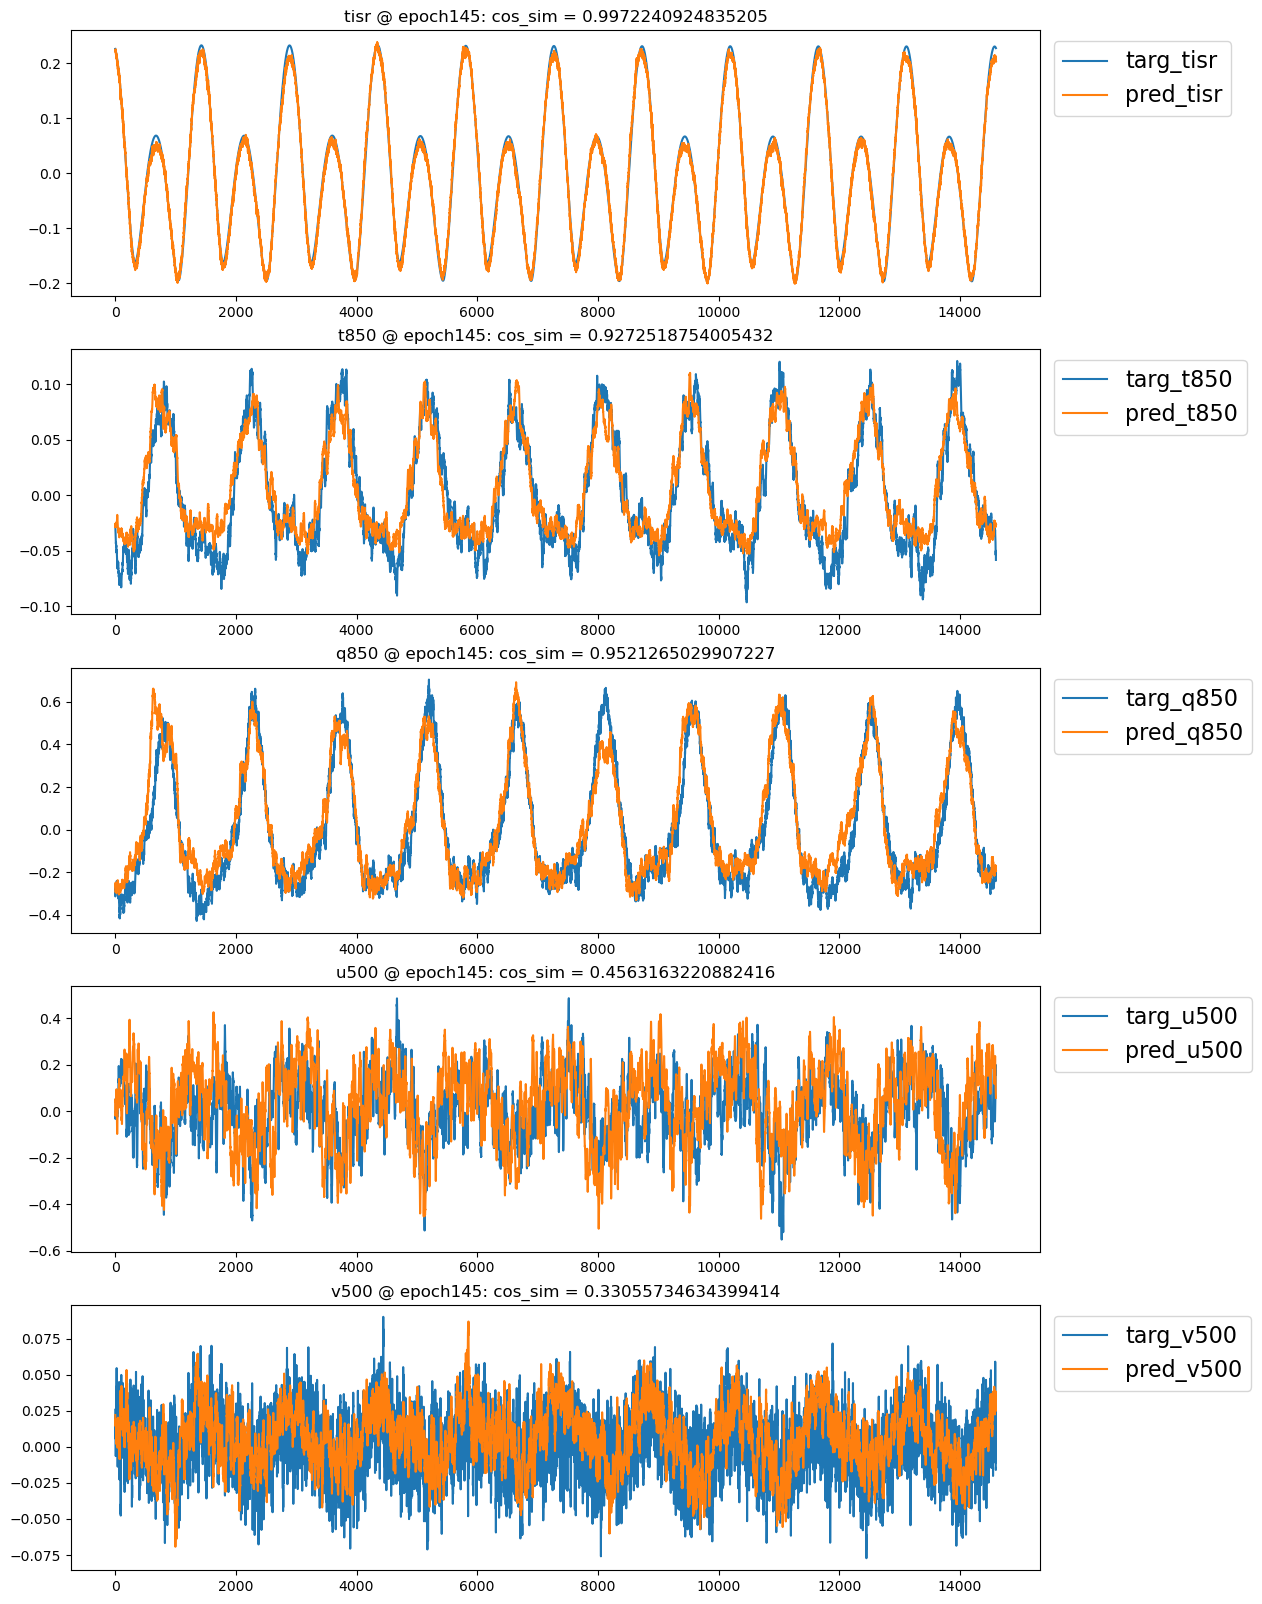

In [72]:
true_clim_t = torch.mean(tt,dim=(-1,-2))
pred_clim_t = torch.mean(pp,dim=(-1,-2))
fig,axs = plt.subplots(nvars,1, figsize=(w*2.5,h*nvars))
for ii in range(nvars):
    pcm1 = axs[ii].plot(true_clim_t[:,ii],label=f"targ_{vars[ii]}")
    pcm2 = axs[ii].plot(pred_clim_t[:,ii],label=f"pred_{vars[ii]}")
    ppi = pred_clim_t[1460:,ii].reshape(1, -1)
    tti = true_clim_t[1460:,ii].reshape(1, -1)
    cos_sim = cosine_similarity(ppi, tti)[0, 0]
    axs[ii].set_title(f"{vars[ii]} @ epoch{ei}: cos_sim = {cos_sim}")
    axs[ii].legend(loc='upper left', bbox_to_anchor=(1.003, 1),fontsize=16)

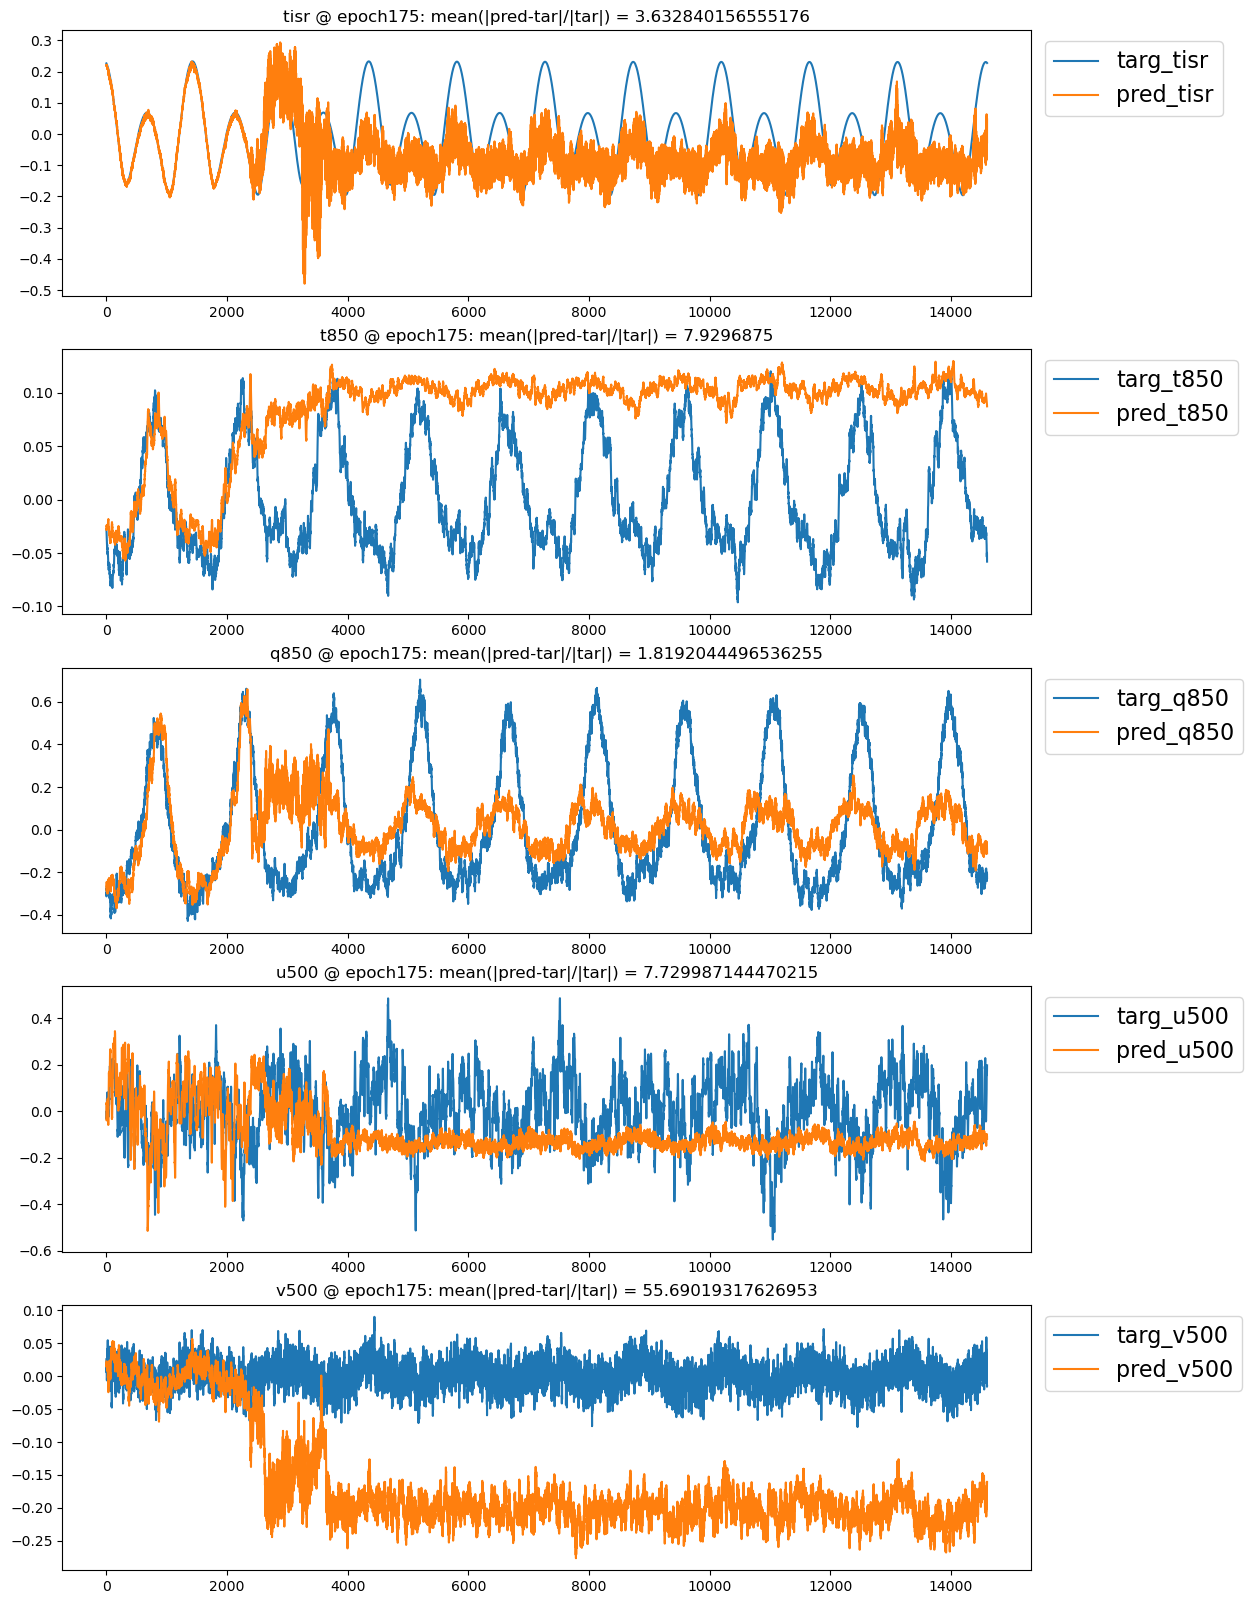

In [68]:
true_clim_t = torch.mean(tt,dim=(-1,-2))
pred_clim_t = torch.mean(pp,dim=(-1,-2))
fig,axs = plt.subplots(nvars,1, figsize=(w*2.5,h*nvars))
for ii in range(nvars):
    pcm1 = axs[ii].plot(true_clim_t[:,ii],label=f"targ_{vars[ii]}")
    pcm2 = axs[ii].plot(pred_clim_t[:,ii],label=f"pred_{vars[ii]}")
    axs[ii].set_title(f"{vars[ii]} @ epoch{ei}: mean(|pred-tar|/|tar|) = {torch.mean(torch.abs(true_clim_t[:,ii] - pred_clim_t[:,ii])/torch.abs(true_clim_t[:,ii]))}")
    axs[ii].legend(loc='upper left', bbox_to_anchor=(1.003, 1),fontsize=16)

In [61]:
true_clim_t = torch.mean(tt,dim=(-1,-2))
pred_clim_t = torch.mean(pp,dim=(-1,-2))
fig,axs = plt.subplots(nvars,1, figsize=(w*2.5,h*nvars))
for ii in range(nvars):
    pcm1 = axs[ii].plot(true_clim_t[:,ii],label=f"targ_{vars[ii]}")
    pcm2 = axs[ii].plot(pred_clim_t[:,ii],label=f"pred_{vars[ii]}")
    axs[ii].set_title(f"{vars[ii]} @ epoch{ei}: mean(|pred-tar|/|tar|) = {torch.mean(torch.abs(true_clim_t[:,ii] - pred_clim_t[:,ii])/torch.abs(true_clim_t[:,ii]))}")
    axs[ii].legend(loc='upper left', bbox_to_anchor=(1.003, 1),fontsize=16)

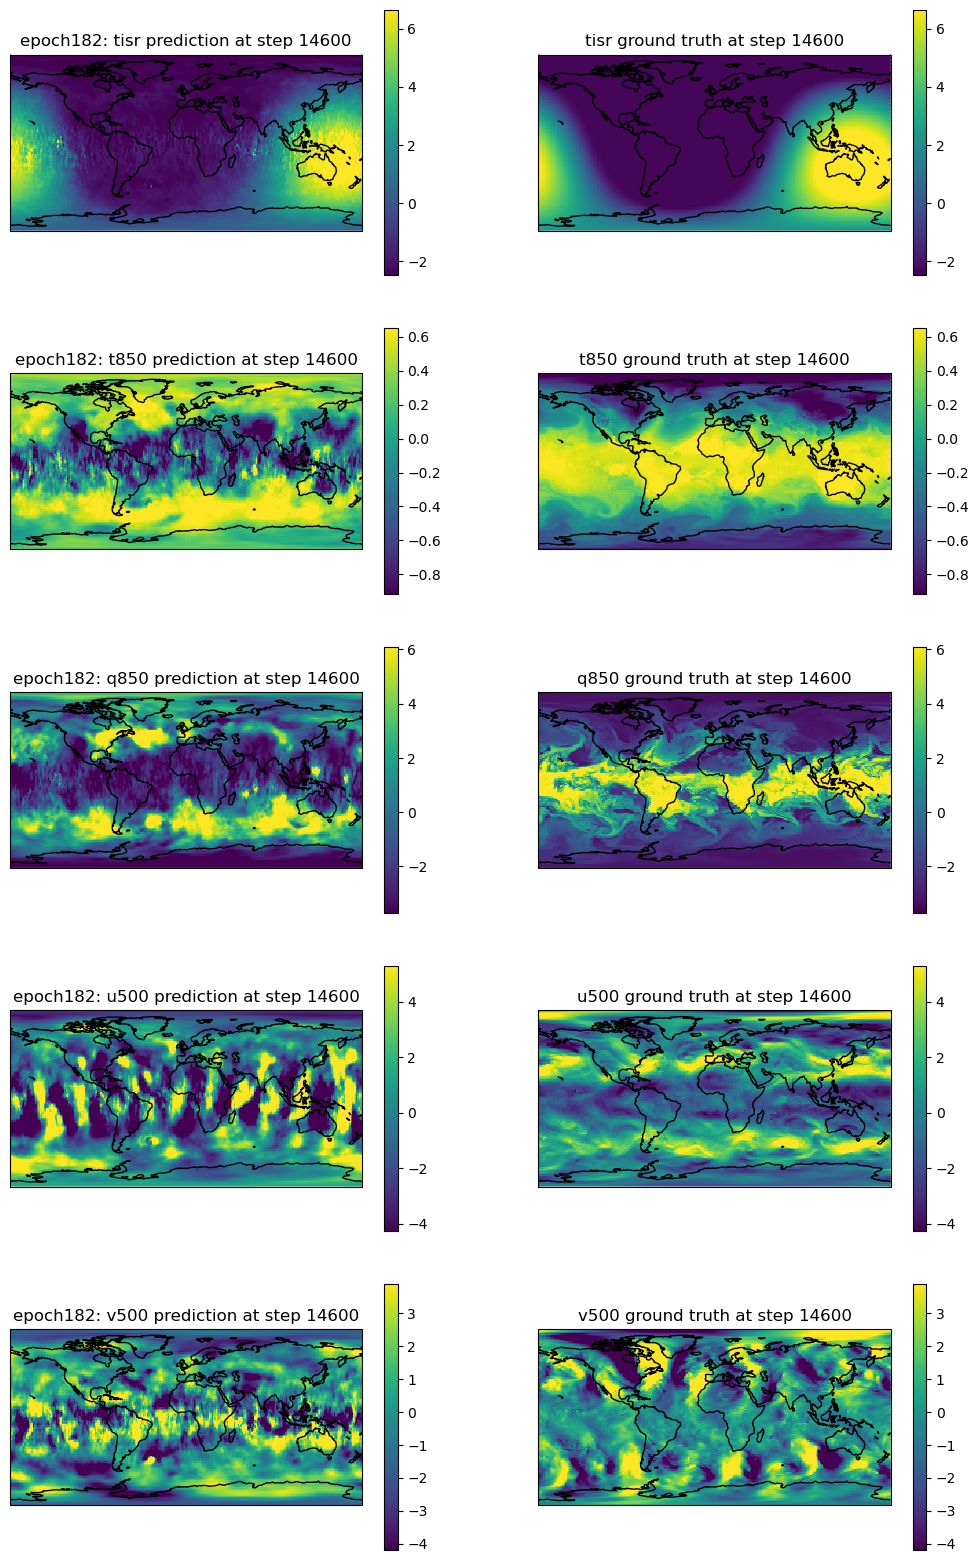

In [62]:
ss = pp.shape[0]
fig,axs = plt.subplots(nvars,2, figsize=(w*2.5,h*nvars),subplot_kw={'projection': ccrs.PlateCarree()},squeeze=False)
for ii in range(nvars):
    pii = pp[ss-1,ii,:,:]
    tii = tt[ss-1,ii,:,:]
    combined_values = np.concatenate([pii.flatten(), tii.flatten()])
    cmin, cmax = np.nanquantile(combined_values, [0.05, 0.95])
        
    pcm = axs[ii,0].pcolormesh(Lon,Lat,pii,vmin=cmin, vmax=cmax,cmap='viridis', shading='auto')
    axs[ii,0].coastlines()
    axs[ii,0].set_title(f"epoch{ei}: {vars[ii]} prediction at step {ss}")
    fig.colorbar(pcm, ax=axs[ii,0])
    
    pcm1 = axs[ii,1].pcolormesh(Lon,Lat,tii,vmin=cmin, vmax=cmax,cmap='viridis', shading='auto')
    axs[ii,1].coastlines()
    axs[ii,1].set_title(f"{vars[ii]} ground truth at step {ss}")
    fig.colorbar(pcm1, ax=axs[ii,1])

# The END